In [1]:
import numpy as np
import scipy as sc
from scipy import integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#defining a single Lorentzian peak SD function. This function takes the frequency 'omega' and a set of parameters
#'SDargs' and returns a Lorentzian shaped SD
#omega: frequency at which to evaluate the SD
#SDargs: a list containing the parameters [gamma, nu, lam]
#gamma: the width of the Lorentzian peak, $\gamma$
#nu: central frequency of the Lorentzian peak, $\nu$
#lam: coupling strength, $\lambda$
def SDlorentzian(omega, SDargs):

    #extracting the parameters from SD args
    #gamma: width parameter
    gamma = SDargs[0] 
    #nu: central frequency
    nu = SDargs[1] 
    #lam: coupling strength
    lam = SDargs[2]
    
    #Lorentzian form of the SD
    lorentzian = (omega*lam**2*gamma)/((omega**2 - nu**2)**2 + (gamma*omega)**2)

    #return the value of the Lorentzian shaped SD at frequency omega
    return(lorentzian)

#define the total SD function which is a sum of Lorentzian peaks
#omega: frequency at which to evaluate the SD
#SDargslist: a list of argument sets, where each set corresponds to a Lorentzian peak. Each set in SDargslist is of
#the form [gamma, nu, lam]
def SD0(omega, SDargslist):
    
    #initialise the total SD to zero
    SD0 = 0
    
    #loop over the list of SD arguments (one set for each Lorentzian peak)
    for i in range(len(SDargslist)):
        #add the contribution from each Lorentzian peak to the total SD
        SD0 += SDlorentzian(omega, SDargslist[i])
    
    #return the total SD
    return(SD0)

In [3]:
#function to calculate the frequency of the RC and the coupling strength between the RC and the two-level system
#based on the provided SD function
#SD: SD function before the mapping
#SDargs: arguments for the SD function before the mapping
def frequencyandcouplingstrength(SD, SDargs):
    
    #define the integrand function for calculating the numerator of the frequency and coupling strength
    def func1(omegap, SD, SDargs):
        func = omegap*SD(omegap, SDargs)
        return(func)
    
    #define the integrand for calculating the denominator of the frequency. This avoids division by zero by 
    #handling the omegap = 0 case
    def func2(omegap, SD, SDargs):
        
        if omegap == 0:
            #avoid division by zero, use a small number instead
            func = SD(0.00000000001, SDargs)/0.00000000001
            
        else:
            func = SD(omegap, SDargs)/omegap
        
        return(func)
    
    #perform numerical integration of func1 over the range [0, ∞) 
    ans1, err1 = quad(func1, 0, np.inf, args=(SD, SDargs), limit=1000)
    
    #perform numerical integration of func2 over the range [0, ∞)
    ans2, err2 = quad(func2, 0, np.inf, args=(SD, SDargs), limit=1000)
    
    #calculate the frequency
    freq = np.sqrt(ans1/ans2)
    
    #calculate the coupling strength
    couplingstrength = np.sqrt(ans1/freq)
    
    #return both the coupling strength and the frequency
    return(couplingstrength, freq)

#function to calculate the reaction coordinate SD
#omega: frequency at which to evaluate the SD
#SD: the original SD function before the mapping
#SDargs: arguments for the original SD function
#couplingstrength: the coupling strength between the RC and the two-level system (calculated using previous 
#function)
def JRC(omega, SD, SDargs, couplingstrength):
    
    #determine the sign of JRC based on the frequency omega
    sign = 1
    if omega < 0:
        #if frequency is negative, change sign and take the absolute value of omega
        omega = np.abs(omega)
        sign = -1
        
    #define the integrand for the Cauchy integral over the SD
    def J0_cauchy(omegap, SD, SDargs, omega):
        J = SD(omegap, SDargs)/(omegap-omega)
        return(J)
    
    #perform numerical integration over different frequency ranges for JRC calculation
    
    #integrating using the cauchy principal value over the range (-∞, omega/4]
    ans1, err1 = quad(J0_cauchy, -np.inf, omega/4, args = (SD, SDargs, omega))
    
    #if omega = 0, we change the integration range for numerical stability
    if omega == 0:
        ans2, err2 = quad(J0_cauchy, 0, 1, args = (SD, SDargs, omega))
        
    else: 
        #weighted integration over the range [omega/4, omega+1]
        ans2, err2 = quad(SD, omega/4, omega+1, args=(SDargs), weight = 'cauchy', wvar = omega, limit=10000)
        
    #perform another integration over the range [omega+1, ∞)
    ans3, err3 = quad(J0_cauchy, omega+1, np.inf, args = (SD, SDargs, omega))
    
    #compute the reaction coordinate SD, JRC
    JRC = sign*(couplingstrength**2*SD(omega, SDargs))/((ans1 + ans2 + ans3)**2 + np.pi**2*SD(omega, SDargs)**2)
        
    #return the computed JRC value
    return(JRC) 

In [4]:
#function to choose the dimension of the reaction coordinate based on the provided spectral density arguments
def choose_dimension(SDargs):
    
    #extracting the parameters from SDargs
    
    #nu: central frequency
    nu = SDargs[1] 
    #lam: coupling strength
    lam = SDargs[2]
    
    #dimRC is assigned based on the conditions below
    if 0.54 <= nu <= 0.57:
        if 0.21 < lam <= 0.25:
            dimRC = 10
        if 0.18 < lam <= 0.21:
            dimRC = 9
        if 0.14 < lam <= 0.18:
            dimRC = 8
        if 0.1 <= lam <= 0.14:
            dimRC = 7
    
    if 0.57 <= nu < 0.61:
        if 0.19 < lam <= 0.25:
            dimRC = 9
        if 0.15 <= lam <= 0.19:
            dimRC = 8
    
    if 0.61 <= nu < 0.7:
        if 0.2 < lam <= 0.25:
            dimRC = 8
        if 0.12 < lam <= 0.2:
            dimRC = 7
        if 0.1 <= lam <= 0.12:
            dimRC = 6
    
    if 0.7 <= nu < 0.75:
        if 0.19 < lam <= 0.25:
            dimRC = 7
        if 0.11 < lam <= 0.19:
            dimRC = 6
        if 0.1 <= lam <= 0.11:
            dimRC = 5
    
    if 0.75 <= nu < 0.88:
        if 0.13 < lam <= 0.25:
            dimRC = 6
        if 0.1 <= lam <= 0.13:
            dimRC = 5 
            
    if 0.88 <= nu < 1.2:
        if 0.1 < lam <= 0.25:
            dimRC = 5
        if 0.1 == lam:
            dimRC = 4
        
    if 1.2 <= nu < 1.8:
        dimRC = 4
        
    if 1.8 < nu:
        dimRC = 3
        
    #return the chosen dimension of the reaction coordinate
    return(dimRC)

In [5]:
#Function to perform the reaction coordinate mapping and compute the time evolution of the state of the two-level
#system using three reaction coordinates
#dimRC1 - the dimension of the Hilbert space of the first reaction coordinate
#dimRC2 - the dimension of the Hilbert space of the second reaction coordinate
#dimRC3 - the dimension of the Hilbert space of the third reaction coordinate
#beta - inverse temperature
#time - array of times at which to calculate the state of the system
#SD0 - the origianl SD function before the mapping
#SD0args - arguments for the SD function SD0
#JRC - Reaction coordinate spectral density function
#omega0 - level spacing of the two-level system, $\omega_0$
def RC_mapping_threeRCs(dimRC1, dimRC2, dimRC3, beta, time, SD0, SD0args, JRC, omega0):
    
    #calculate the coupling strengths between the two-level system and the RCs (g1, g2 and g3) and the frequencies 
    #of the RCs (Omega1, Omega2 and Omega3)
    g1, Omega1 = frequencyandcouplingstrength(SDlorentzian, SD0args[0])
    g2, Omega2 = frequencyandcouplingstrength(SDlorentzian, SD0args[1])
    g3, Omega3 = frequencyandcouplingstrength(SDlorentzian, SD0args[2])
    
    #Define the dimensions of the Hilbert spaces of the two-level system (dimS) and the total system + RCs (dimtot) 
    dimS = 2
    dimtot = dimS*dimRC1*dimRC2*dimRC3
    
    #Define the annihilation operator for the RCs and the position operator x
    b1 = np.diag(np.sqrt(np.arange(1, dimRC1)), 1) #annihilation operator in the Hilbert space of the first RC
    b2 = np.diag(np.sqrt(np.arange(1, dimRC2)), 1) #annihilation operator in the Hilbert space of the second RC
    b3 = np.diag(np.sqrt(np.arange(1, dimRC3)), 1) #annihilation operator in the Hilbert space of the third RC
    
    x1 = b1 + b1.conj().transpose() #position operator in the Hilbert space of the first RC
    x2 = b2 + b2.conj().transpose() #position operator in the Hilbert space of the second RC
    x3 = b3 + b3.conj().transpose() #position operator in the Hilbert space of the third RC
    
    #tensor product to apply to the entire system + RCs
    xT1 = np.kron(np.kron(np.kron(np.eye(dimS), x1), np.eye(dimRC2)), np.eye(dimRC3))
    #tensor product to apply to the entire system + RCs
    xT2 = np.kron(np.kron(np.kron(np.eye(dimS), np.eye(dimRC1)), x2), np.eye(dimRC3))
    #tensor product to apply to the entire system + RCs
    xT3 = np.kron(np.kron(np.kron(np.eye(dimS), np.eye(dimRC1)), np.eye(dimRC2)), x3)

    #initial state of the two-level system
    rhoS0 = np.array([[1/2,1/2],[1/2,1/2]])
    #initial state of the first RC: thermal state based on beta and the frequency Omega1
    rhoRC01 = sc.linalg.expm(-beta*Omega1*(np.diag(np.arange(dimRC1))))/np.matrix.trace(sc.linalg.expm(-beta*Omega1*(np.diag(np.arange(dimRC1)))))
    #initial state of the second RC: thermal state based on beta and the frequency Omega2
    rhoRC02 = sc.linalg.expm(-beta*Omega2*(np.diag(np.arange(dimRC2))))/np.matrix.trace(sc.linalg.expm(-beta*Omega2*(np.diag(np.arange(dimRC2)))))
    #initial state of the third RC: thermal state based on beta and the frequency Omega3
    rhoRC03 = sc.linalg.expm(-beta*Omega3*(np.diag(np.arange(dimRC3))))/np.matrix.trace(sc.linalg.expm(-beta*Omega3*(np.diag(np.arange(dimRC3)))))
    #total initial state
    rhotot0 = np.kron(np.kron(np.kron(rhoS0, rhoRC01), rhoRC02), rhoRC03)

    #Define the Pauli-matrices for the system
    sz = np.array([[1,0],[0,-1]]) #$\sigma_z$ (Pauli z matrix)
    sx = np.array([[0, 1],[1, 0]]) #$\sigma_x$ (Pauli x matrix)

    #Define the Hamiltonians for the system, the RC, and their interaction
    #system Hamiltonian
    HS = np.kron(np.kron(np.kron(omega0*sz/2, np.eye(dimRC1)), np.eye(dimRC2)), np.eye(dimRC3))
    #Hamiltonian of the first RC
    HRC1 = np.kron(np.kron(np.kron(np.eye(dimS), Omega1*b1.conj().transpose()@b1), np.eye(dimRC2)), np.eye(dimRC3))
    #interaction Hamiltonian between the system and the first RC
    HI1 = np.kron(np.kron(np.kron(g1*sz, x1), np.eye(dimRC2)), np.eye(dimRC3))
    #Hamiltonian of the second RC
    HRC2 = np.kron(np.kron(np.kron(np.eye(dimS), np.eye(dimRC1)), Omega2*b2.conj().transpose()@b2), np.eye(dimRC3))
    #interaction Hamiltonian between the system and the second RC
    HI2 = np.kron(np.kron(np.kron(g2*sz, np.eye(dimRC1)), x2), np.eye(dimRC3))
    #Hamiltonian of the third RC
    HRC3 = np.kron(np.kron(np.kron(np.eye(dimS), np.eye(dimRC1)), np.eye(dimRC2)), Omega3*b3.conj().transpose()@b3)
    #interaction Hamiltonian between the system and the third RC
    HI3 = np.kron(np.kron(np.kron(g3*sz, np.eye(dimRC1)), np.eye(dimRC2)), x3)

    #total Hamiltonian: sum of the system, RC and interaction Hamiltonians
    Htot = HS + HRC1 + HI1 + HRC2 + HI2 + HRC3 + HI3

    #Diagonalise the total Hamiltonian to obtain eigenvalues and eigenvectors
    E, v = np.linalg.eig(Htot)
    
    #Define the Gamma function
    def Gamma(omega, SD, SDargs, beta, couplingstrength):
        if omega>0:
            Gamma = np.pi*JRC(omega, SD, SDargs, couplingstrength)*(1/(np.exp(beta*omega) - 1))
            
        if omega ==0:
            Gamma = np.pi*JRC(0.00000000001, SD, SDargs, couplingstrength)*(1/(np.exp(beta*0.00000000001) - 1))

        if omega<0:
            Gamma = np.pi*JRC(np.abs(omega), SD, SDargs, couplingstrength)*(1/(np.exp(beta*np.abs(omega)) - 1) + 1)
        return(Gamma)
    
    
    #intialise matrices A1, Aplus1, Aminus1, A2, Aplus2, Aminus2, A3, Aplus3, and Aminus3
    A1 = np.zeros((dimtot, dimtot))
    Aplus1 = np.zeros((dimtot, dimtot))
    Aminus1 = np.zeros((dimtot, dimtot))
    A2 = np.zeros((dimtot, dimtot))
    Aplus2 = np.zeros((dimtot, dimtot))
    Aminus2 = np.zeros((dimtot, dimtot))
    A3 = np.zeros((dimtot, dimtot))
    Aplus3 = np.zeros((dimtot, dimtot))
    Aminus3 = np.zeros((dimtot, dimtot))

    #Loop through all pairs of eigenstates and accumulate the elements of the A1, Aplus1, Aminus1, A2, Aplus2, 
    #Aminus2, A3, Aplus3 and Aminus3 matrices
    for i in range(dimtot):
        for j in range(dimtot):
            A1[i,j] = (v[:,[i]]).conj().transpose()@xT1@v[:,[j]]
            Aplus1 += Gamma(E[i]-E[j], SDlorentzian, SD0args[0], beta, g1)*A1[i,j]*(v[:,[i]]@((v[:,[j]]).conj().transpose()))
            Aminus1 += Gamma(E[j]-E[i], SDlorentzian, SD0args[0], beta, g1)*A1[i,j]*(v[:,[i]]@((v[:,[j]]).conj().transpose()))
            
            A2[i,j] = (v[:,[i]]).conj().transpose()@xT2@v[:,[j]]
            Aplus2 += Gamma(E[i]-E[j], SDlorentzian, SD0args[1], beta, g2)*A2[i,j]*(v[:,[i]]@((v[:,[j]]).conj().transpose()))
            Aminus2 += Gamma(E[j]-E[i], SDlorentzian, SD0args[1], beta, g2)*A2[i,j]*(v[:,[i]]@((v[:,[j]]).conj().transpose()))
            
            A3[i,j] = (v[:,[i]]).conj().transpose()@xT3@v[:,[j]]
            Aplus3 += Gamma(E[i]-E[j], SDlorentzian, SD0args[2], beta, g3)*A3[i,j]*(v[:,[i]]@((v[:,[j]]).conj().transpose()))
            Aminus3 += Gamma(E[j]-E[i], SDlorentzian, SD0args[2], beta, g3)*A3[i,j]*(v[:,[i]]@((v[:,[j]]).conj().transpose()))
            
    #Defining an array to store the state of the reduced system at each time
    rhoSt = np.zeros((dimS, dimS, len(time)), dtype=complex)
    #intialise the system density matrix at time 0
    rhoSt[:,:,0] = rhoS0
    
    #define the master equation for time evolution
    def ME(rho):
        drho=-1j*(Htot@rho-rho@Htot)+ -xT1@Aplus1@rho + xT1@rho@Aminus1 - rho@Aminus1@xT1 + Aplus1@rho@xT1
        drho += -xT2@Aplus2@rho + xT2@rho@Aminus2 - rho@Aminus2@xT2 + Aplus2@rho@xT2
        drho += -xT3@Aplus3@rho + xT3@rho@Aminus3 - rho@Aminus3@xT3 + Aplus3@rho@xT3
        return(drho)
    
    #time step for time evolution
    dt = time[1] - time[0]
    
    #initialize the total system + RC state with the initial density matrix
    rhoc = rhotot0
    
    #time evolution using the 4th order Runge-Kutta method
    for t in tqdm(range(len(time)-1)):
        k1=ME(rhoc)
        k2=ME(rhoc+dt*k1/2)
        k3=ME(rhoc+dt*k2/2)
        k4=ME(rhoc+dt*k3)
        rhoc=rhoc+dt/6*(k1+2*k2+2*k3+k4)
        
        #calculate the reduced density matrix for the system by tracing out the RCs
        rhoSt[:,:,t+1] = np.trace(rhoc[:,:].reshape(dimS, dimRC1*dimRC2*dimRC3, dimS, dimRC1*dimRC2*dimRC3), axis1=1, axis2=3)
    
    #return the time-evolved system density matrix
    return(rhoSt)

In [6]:
#Function to generate a single training example for a machine learning model. It simulates the time evolution of 
#the system using the raction coordinate mapping, and calculates the expectation values of the Pauli matrices 
#($\sigma_x$, $\sigma_y$, $sigma_z$).
#time: array of time points at which to calculate the state of the system
#gamma_l and gamma_h: lower and upper bounds for the width parameter ($\gamma$) to sample from
#nu_l and nu_h: lower and upper bounds for the central frequency ($\nu$) to sample from
#lam_l and lam_h: lower and upper bounds for the coupling strength ($\lambda$) to sample from
#temp: temperature
#Omega0: system frequency
def Generate_Training_Example(time, gamma_l, gamma_h, nu_l, nu_h, lam_l, lam_h, temp, omega0):
    
    #define the systems initial density matrix
    rho0 = np.array([[1/2,1/2],[1/2,1/2]])
    
    #define the Pauli matrices
    sx = np.array([[0, 1],[1, 0]]) #$\sigma_x$ (Pauli x matrix)
    sy = np.array([[0, -1j],[1j, 0]]) #$\sigma_y$ (Pauli y matrix)
    sz = np.array([[1, 0],[0, -1]]) #$\sigma_z$ (Pauli z matrix)
    
    #intialise arrays to store the expectation values of the Pauli matrices over time
    sigmaxt = np.zeros(len(time)) #Expectation value for $\sigma_x$
    sigmayt = np.zeros(len(time)) #Expectation value for $\sigma_y$
    sigmazt = np.zeros(len(time)) #Expectation value for $\sigma_z$
    
    #set the intial values of the expectation values
    sigmaxt[0] = np.trace(sx@rho0).real
    sigmayt[0] = np.trace(sy@rho0).real
    sigmazt[0] = np.trace(sz@rho0).real
    
    #randomly sample values for $\gamma_1$ (width parameter), $\nu_1$ (central frequency), and $\lambda_1$ 
    #(coupling strength) for the first Lorentzian peak
    gamma1 = np.random.uniform(gamma_l, gamma_h) #random $|gamma_1$ in range [gamma_l, gamma_h]
    nu1 = np.random.uniform(nu_l, nu_h) #random $|nu_1$ in range [nu_l, nu_h]
    lam1 = np.random.uniform(lam_l, lam_h) #random $|lambda_1$ in range [lam_l, lam_h]
    
    #create the argument list for the first Lorentzian peak
    SDargs1 = [gamma1, nu1, lam1]
    
    #randomly sample values for $|gamma_2$ (width parameter), $|nu_2$ (central frequency), and $|lambda_2$
    #(coupling strength) for the second Lorentzian peak
    gamma2 = np.random.uniform(gamma_l, gamma_h) #random $|gamma_2$ in range [gamma_l, gamma_h]
    nu2 = np.random.uniform(nu_l, nu_h) #random $|nu_2$ in range [nu_l, nu_h]
    lam2 = np.random.uniform(lam_l, lam_h) #random $|lambda_2$ in range [lam_l, lam_h]
    
    #create the argument list for the second Lorentzian peak
    SDargs2 = [gamma2, nu2, lam2]
    
    #randomly sample values for $|gamma_3$ (width parameter), $|nu_3$ (central frequency), and $|lambda_3$ 
    #(coupling strength) for the third Lorentzian peak
    gamma3 = np.random.uniform(gamma_l, gamma_h) #random $|gamma_3$ in range [gamma_l, gamma_h]
    nu3 = np.random.uniform(nu_l, nu_h) #random $|nu_3$ in range [nu_l, nu_h]
    lam3 = np.random.uniform(lam_l, lam_h) #random $|lambda_3$ in range [lam_l, lam_h]
        
    #create the argument list for the third Lorentzian peak
    SDargs3 = [gamma3, nu3, lam3]
    
    #create the list of arguments for calculating the total SD
    SDargs = [SDargs1, SDargs2, SDargs3]
    
    #choose the dimension of the Hilbert space for the first RC based on the parameters for the first Lorentzian
    dimRC1 = choose_dimension(SDargs1)
    #choose the dimension of the Hilbert space for the second RC based on the parameters for the second Lorentzian
    dimRC2 = choose_dimension(SDargs2)
    #choose the dimension of the Hilbert space for the third RC based on the parameters for the third Lorentzian
    dimRC3 = choose_dimension(SDargs3)
    
    #Initialise an array to store the system parameters and dimensions of the RCs
    Y = np.zeros(14)
    Y[0] = 3 #the number of RCs used to simulate the dynamics
    Y[1] = gamma1 #sampled $|gamma_1$ value
    Y[2] = nu1 #sampled $|nu_1$ value
    Y[3] = lam1 #sampled $|lambda_1$ value
    Y[4] = dimRC1 #chosen Hilbert space dimension for the first RC
    Y[5] = gamma2 #sampled $|gamma_2$ value
    Y[6] = nu2 #sampled $|nu_2$ value
    Y[7] = lam2 #sampled $lambda_2$ value
    Y[8] = dimRC2 #chosen Hilbert space dimension for the second RC
    Y[9] = gamma3 #sampled $|gamma_3$ value
    Y[10] = nu3 #sampled $|nu_3$ value
    Y[11] = lam3 #sampled $|lambda_3$ value
    Y[12] = dimRC3 #chosen Hilbert space dimension for the third RC
    Y[13] = temp #temperature
    
    #calculating the inverse temperature
    beta = 1/temp
    
    #perform the RC mapping to calculate the time evolution of the density matrix
    rhot = RC_mapping_threeRCs(dimRC1, dimRC2, dimRC3, beta, time, SD0, SDargs, JRC, omega0)
    
    #loop through the time array and calculate the expection values for $\sigma_x$, $\sigma_y$, and $\sigma_z$ at
    #each point.
    for i in range(len(time)-1):
        sigmaxt[i+1] = np.trace(sx@rhot[:,:,i+1]).real #expectation value of $\sigma_x$ at time time[i+1]
        sigmayt[i+1] = np.trace(sy@rhot[:,:,i+1]).real #expectation value of $\sigma_y$ at time time[i+1]
        sigmazt[i+1] = np.trace(sz@rhot[:,:,i+1]).real #expectation value of $\sigma_z$ at time time[i+1]
        
    #return the time-evolved expectation values of $\sigma_x$, $\sigma_y$, $\sigma_z$
    return(sigmaxt, sigmayt, sigmazt, Y)

In [7]:
#define the time array for the simulations (0 to 50 with 800 time points)
t = np.linspace(0, 50, 800)

#Define the ranges for the parameters $\lambda$ (coupling strength), $\gamma$ (width parameter), and $\nu$ (central
#frequency)
lam_l = 0.1 #lower bound for $\lambda$
lam_h = 0.25 #upper bound for $\lambda$

gamma_l = 0.15 #lower bound for $\gamma$
gamma_h = 0.25 #upper bound for $\gamma$

nu_l = 0.54 #lower bound for $\nu$
nu_h = 2 #upper bound for $nu$

#Define the system parameters
omega0 = 1 #system frequency
temp = 0.5 #temperature

#number of training examples to generate
n_training = 1

#initialise arrays to store the training data. Xtrainx, Xtrainy, and Xtrainz will store the time evolution of the 
#expectation values
Xtrainx = np.zeros((n_training, len(t)))
Xtrainy = np.zeros((n_training, len(t)))
Xtrainz = np.zeros((n_training, len(t)))
#Ytrain will store the corresponding parameters for each training example
Ytrain = np.zeros((n_training, 14))
    
#loop over the number of training examples to generate
for i in range(n_training):
    Xtrainx[i,:], Xtrainy[i,:], Xtrainz[i,:], Ytrain[i,:] = Generate_Training_Example(t, gamma_l, gamma_h, nu_l, nu_h, lam_l, lam_h, temp, omega0)

100%|█████████████████████████████████████████| 799/799 [06:46<00:00,  1.97it/s]


## Pure Dephasing

In [8]:
#Function to calculate the decoherence function as a funcion of time, t
#SD: SD function
#SDargs: arguments for the SD function
#beta: inverse temperature
#t: time array at which to calculate the decoherence function
def decoherence(SD, SDargs, beta, t):
    
    #Defining the integrand function to be used in the numerical integration. This function depends on the 
    #frequency omega, SD arguments SDargs, the inverse temperature beta, and time t
    def func(omega, SDargs, beta, t):
        
        #handle the case where omega is 0 to avoid division by zero
        if omega==0:
            SD(0.00000000001, SDargs)*((1 - np.cos(0.00000000001*t))/0.00000000001**2)/(np.tanh(beta*0.00000000001/2))
        #for non-zero omega, calculate the integrand
        else:
            func = SD(omega, SDargs)*((1 - np.cos(omega*t))/omega**2)/(np.tanh(beta*omega/2))
        
        #return the integrand
        return(func)
    
    #perform numerical integration of the function over the frequency range [0, ∞]
    dec, err = integrate.quad(func, 0, np.inf, args = (SDargs, beta, t), limit=10000) 
    
    #multuply the result by 4 as per the model's formula 
    dec *= 4
    
    #return the calculated decoherence value for time t
    return(dec)

In [9]:
#function to calculate the density matrix of the system at a given time t
#SD: SD function
#SDargs: arguments for the SD function
#rho0: initial density matrix of the system
#beta: inverse temperature
#t: time at which to calculate the density matrix
#omega0: system frequency
def rhot(SD, SDargs, rho0, beta, t, omega0):
    
    #calculating the value of the decoherence function at time t
    dec = decoherence(SD, SDargs, beta, t)
    
    #calculate the time-evolved density matrix
    rhot = np.array([[rho0[0,0], rho0[0,1]*np.exp(-dec)*(np.cos(omega0*t) -1j*np.sin(omega0*t))],[rho0[1,0]*np.exp(-dec)*(np.cos(omega0*t) + 1j*np.sin(omega0*t)), rho0[1,1]]])
    
    #return the time-evolved density matrix
    return(rhot)

In [10]:
#define an array of time points at which to calculate the density matrix. the time ranges from 0 to 50 with 2000 
#time points
texact = np.linspace(0, 50, 2000)

#extract parameters from the Ytrain array for the first training example
gamma1 = Ytrain[0,1] #$\gamma_1$
nu1 = Ytrain[0,2] #$|nu_1$
lam1 = Ytrain[0,3] #$|lambda_1$
gamma2 = Ytrain[0,5] #$|gamma_2$
nu2 = Ytrain[0,6] #$|nu_2$
lam2 = Ytrain[0,7] #$\lambda_2$
gamma3 = Ytrain[0,9] #$|gamma_3$
nu3 = Ytrain[0,10] #$|nu_3$
lam3 = Ytrain[0,11] #$|lambda_3$

#define the arguments for the first Lorentzian peak
SDargs1 = [gamma1, nu1, lam1]
#define the arguments for the second Lorentzian peak
SDargs2 = [gamma2, nu2, lam2]
#define the arguments for the third Lorentzian peak
SDargs3 = [gamma3, nu3, lam3]
#define the list of arguments for the total SD
SDargs = [SDargs1, SDargs2, SDargs3]

#setting the system frequency
omega0 = 1
#setting the temperature
temp = 0.5
#calculating the inverse temperature
beta = 1/temp

#define the initial density matrix
rho0 = np.array([[1/2, 1/2],[1/2, 1/2]])
#initialise an array to store the time-evolved density matrix at each time step
rhotarr = np.zeros((2, 2, len(texact)), dtype=complex)
#set the initial condition
rhotarr[:,:,0] = rho0

#loop through the time points to calculate the density matrix at each time
for j in tqdm(range(len(texact)-1)): #use tqdm for progress tracking
    #calculate the density matrix at the next time step
    rhotarr[:,:,j+1] = rhot(SD0, SDargs, rho0, beta, texact[j+1], omega0)

#define the Pauli x matrix     
sx = np.array([[0,1],[1,0]])

#initialise an array to store the expectation value of $sigma_x$ at each time step
sxt = np.zeros(len(texact))

#loop through each time point to calculate the expectation value of $\sigma_x$
for i in range(len(texact)):
    #calculate the expectaton value
    sxt[i] = np.trace(sx@rhotarr[:,:,i]).real

100%|██████████████████████████████████████| 1999/1999 [00:14<00:00, 139.13it/s]


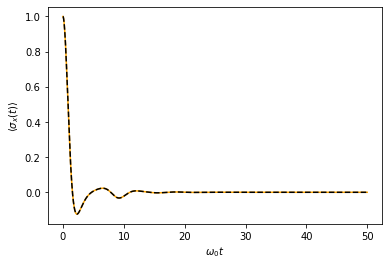

In [11]:
#plot the training data's time evolution of $\sigma_x$ obtained using the reaction coordinate mapping
plt.plot(t, Xtrainx.T, color='orange')

#plot the time evolution from the pure dephasing model
plt.plot(texact, sxt, '--', color='black')

#axis labels
plt.xlabel(r"$\omega_0 t$")
plt.ylabel(r"$\langle \sigma_x (t) \rangle$")
plt.show()